# Accelerate Modeling at Scale with SAS Viya

Instead of building models sequentially and tuning each one to perfection, the following code allows a data scientist to build hundreds of models simultaneously, testing different algorithms for each micro segment leveraging SAS Viya’s in-memory, multi-threaded, distributed compute environment. 

The code automatically generates and assesses all models per micro segment, selects micro segment champion model and top challenger models, and then publishes all models into a model repository per customer segment for governance, monitoring, and publishing.

### SAS Viya environment parameters

In [1]:
import getpass

# Specify your SAS Viya Linux server where SASLogon service is located
viyahost='pdcesx16007.exnet.sas.com'

# Specify your SAS Viya username and password
username='sasdemo'
print('Provide Password:')
password=getpass.getpass()

Provide Password:
········


In [3]:
import swat
from swat.cas.connection import getone, getnext
from swat.clib import SW_CASConnectionEventWatcher, errorcheck
import requests, json
import pandas as pd
import numpy as np
import ipywidgets as widgets
from IPython.display import display
import copy
import params_box
import importlib
from params_box import impute_params, partition_params, get_model_segments, set_model_params, train_non_swat_model, score_non_swat_model
from matplotlib import pyplot as plt
import base64
import os
import pprint
%matplotlib inline

Using TensorFlow backend.


Initiate session and load actionsets

In [4]:
s = swat.CAS(viyahost, 5570, username=username, password=password)

In [5]:
actionsets = ['cardinality', 'sampling', 'fedSQL', 'decisionTree', 'neuralNet', 'regression', 'astore']
for a in actionsets:
    s.loadactionset(a)

NOTE: Added action set 'cardinality'.
NOTE: Added action set 'sampling'.
NOTE: Added action set 'fedSQL'.
NOTE: Added action set 'decisionTree'.
NOTE: Added action set 'neuralNet'.
NOTE: Added action set 'regression'.
NOTE: Added action set 'astore'.


## Define Data, Models, and Parameters

In [7]:
# rejected_vars: 
# customer_state, customer_gender, issue_level2, mfg_samsung, handset_age_grp, state_lat, state_long, Customer_ID_1, forecast_region, customer_address, customer_name, verbatims, resolution, issue_level1, customer_city, customer_primary_phone
tab = params_box.tab()
display(tab)

Use the head method to display first few rows of table

In [8]:
# get caslib and table from input
caslib = params_box.caslib(tab)
table = params_box.table(tab)

# create reference to telco_detractor_table in memory
tbl = s.CASTable(name=table, caslib=caslib)
tbl.head(5)

,Customer_ID,upsell_xsell,churn,lifetime_value,avg_arpu_3m,acct_age,billing_cycle,nbr_contracts_ltd,credit_class,sales_channel,...,call_center,issue_level1,issue_level2,call_category_1,call_category_2,resolution,network_mention,service_mention,price_mention,verbatims
0,471.0,0.0,0.0,1693.8,44.980000,55.000000,4.000000,7.0,prime,Indirect,...,Bothell - IRU,Bill and Payments,Equipment Upgrade Fee,Process & Efficiency,null,Educated - Equipment upgrade fee,0.0,1.0,0.0,Customer service is no longer an option with y...
1,1057.0,0.0,0.0,38682.5,44.989330,47.000000,3.000000,5.0,prime,Indirect,...,Davenport Call Center,Equipment,Equipment Change: Change IMEI/SIM,Product Range & Availability,Upgrades/Renewals,Resolved: Updated IMEI,0.0,0.0,0.0,My phone was stollen 5 days ago I got the new...
2,1177.0,0.0,0.0,5526.4,51.775434,65.000000,7.064706,4.8,prime,Retail,...,Miramar - IRU,Bill and Payments,Process a Payment,Cost of Service,Tech Support,Processed 1 time payment and PCF waived,0.0,0.0,1.0,MTT needs to lower their plans Im consideri...
3,1181.0,0.0,0.0,505.6,51.775434,46.176471,7.064706,4.8,prime,Retail,...,Convergys1 Receivables Management,Account,Reinstate Account,Friendly & Courteous,Process & Efficiency,Unable to Restore/Unsuspend,0.0,0.0,0.0,Phones were turned off due to past due bill S...
4,1185.0,1.0,0.0,9143.2,83.320000,41.000000,5.000000,3.0,prime,Indirect,...,Miramar - IRU,Bill and Payments,Payment Arrangements,Friendly & Courteous,null,Made payment arrangements,0.0,0.0,0.0,It was great


Print summary statistics using cardinality action set

In [9]:
# cardinality action set
tbl.cardinality.summarize(cardinality = dict(name = 'data_card', replace = True))
df_data_card = s.CASTable('data_card').to_frame() # bring the data locally

# get list of nominal and numerical variables
type_c = list(df_data_card.query('_TYPE_ == "C"')['_VARNAME_'])
type_n = list(df_data_card.query('_TYPE_ == "N"')['_VARNAME_'])

# print summary statistics
df_data_card['_PCTMISS_'] = (df_data_card['_NMISS_']/df_data_card['_NOBS_'])*100
print('\n', 'Summary Statistics'.center(90, ' '))
df_data_card[['_VARNAME_','_TYPE_','_PCTMISS_','_MIN_','_MAX_','_MEAN_','_STDDEV_','_SKEWNESS_','_KURTOSIS_']].round(2)

NOTE: Writing cardinality.
NOTE: status = 0.
NOTE: The Cloud Analytic Services server processed the request in 0.526903 seconds.

                                     Summary Statistics                                    


,_VARNAME_,_TYPE_,_PCTMISS_,_MIN_,_MAX_,_MEAN_,_STDDEV_,_SKEWNESS_,_KURTOSIS_
0,Customer_ID,N,0.00,471.00,3999922.00,1871721.32,1214488.00,0.05,-1.25
1,upsell_xsell,N,0.00,0.00,1.00,0.12,0.33,2.32,3.38
2,churn,N,0.00,0.00,1.00,0.04,0.20,4.59,19.07
3,lifetime_value,N,0.00,-14006.00,60740.20,5281.53,5068.84,1.85,5.77
4,avg_arpu_3m,N,1.98,0.00,160.38,60.29,22.88,0.82,2.32
5,acct_age,N,0.00,18.00,168.00,45.17,12.98,0.73,2.30
6,billing_cycle,N,0.00,1.00,12.00,6.64,3.19,-0.05,-0.84
7,nbr_contracts_ltd,N,0.00,1.00,16.65,4.16,2.64,0.97,1.26
8,credit_class,C,0.00,NaN,NaN,NaN,NaN,NaN,NaN
9,sales_channel,C,0.00,NaN,NaN,NaN,NaN,NaN,NaN


Plot distributions of variables

/opt/anaconda3/lib/python3.7/site-packages/swat/cas/table.py:6590: RuntimeWarning: Data downloads are limited to 10000 rows.  To change this limit, set swat.options.cas.dataset.max_rows_fetched to the desired limit.
  RuntimeWarning)


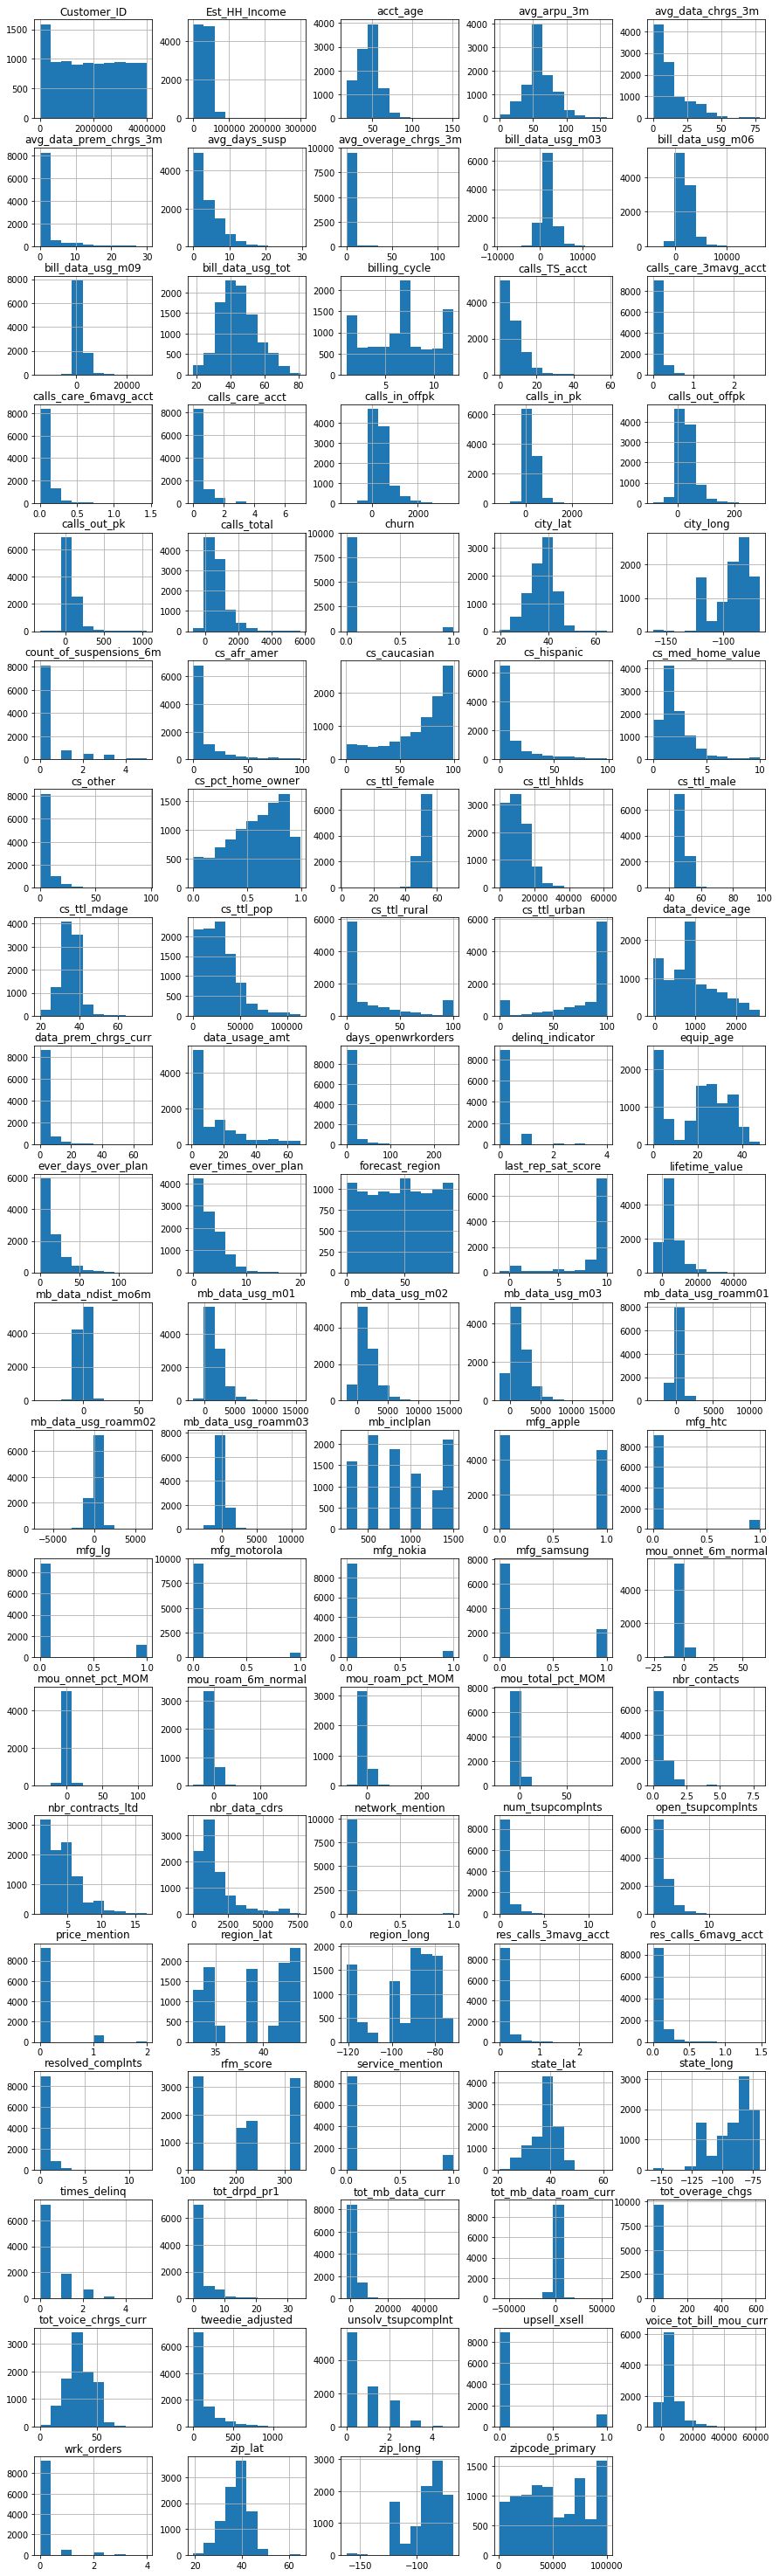

In [13]:
# Use the built in hist() method to plot the distribution of every variable
tbl.hist(figsize = (15,75), layout = (28, 5));

### Define up to 2 segment variables, and specify variables to reject

In [10]:
# obtain inputs from box
params_map = params_box.get(tab)

# extract target, segment1, segment2, and rejected values
target = params_map['setup']['target']
segment1 = params_map['setup']['seg1']
segment2 = params_map['setup']['seg2']
rejected = params_map['setup']['rejected']

# display rejected variables
pd.DataFrame(rejected, columns = ['Rejected Variables'])

,Rejected Variables
0,customer_state
1,customer_gender
2,issue_level2
3,mfg_samsung
4,handset_age_grp
5,state_lat
6,state_long
7,Customer_ID_1
8,forecast_region
9,customer_address


Display unique values of target, segment 1, and segment 2

In [11]:
# display distinct values of Target variable
target_distinct = tbl[target].unique()

# display distinct values of Segment 1 variable
segment1_distinct = tbl[segment1].unique()

# display distinct value of Segment 2 variable
segment2_distinct = tbl[segment2].unique()

df1 = pd.DataFrame(target_distinct, columns = ['Unique target Values'])
df2 = pd.DataFrame(segment1_distinct, columns = ['Unique ' + segment1])
df3 = pd.DataFrame(segment2_distinct, columns = ['Unique ' + segment2])

display(df1, df2, df3)

,Unique target Values
0,0.0
1,1.0


,Unique region
0,Great Lakes
1,Greater Texas
2,Mid Atlantic
3,Midwest
4,Mtn West
5,New England
6,Pacific
7,South
8,Southwest


,Unique handset
0,Apple
1,HTC
2,LG
3,Motorola
4,Nokia
5,Samsung
6,Unknown


Remove rejected variables from input variables, and show which variables remain

In [12]:
# get a list of all inputs
varnames = list(df_data_card['_VARNAME_'])
varnames.remove(target)

# create list of non-rejected variables
inputs = [item for item in varnames if item not in rejected]

# get nominal and numerical variables in inputs
inputs_c = [item for item in inputs if item in type_c]
inputs_n = [item for item in inputs if item in type_n]

# display input variables and their type
inputs_df = pd.DataFrame(inputs, columns=['Variables'])
inputs_df['Type'] = inputs_df['Variables'].apply(lambda x: 'C' if x in inputs_c else 'N')
display(inputs_df)

,Variables,Type
0,Customer_ID,N
1,churn,N
2,lifetime_value,N
3,avg_arpu_3m,N
4,acct_age,N
5,billing_cycle,N
6,nbr_contracts_ltd,N
7,credit_class,C
8,sales_channel,C
9,rfm_score,N


## Generate Segments Based on Chosen Variables

In [13]:
# create segments
class1 = tbl[segment1].unique().tolist()
class2 = tbl[segment2].unique().tolist()

# creates the main segments according to the two inputs
if not segment2:
    segments_main = [{segment1: i} for i in class1]
else:
    segments_main = [{segment1: i, segment2: j} for i in class1 for j in class2]

# create an id for each segment
for idx,val in enumerate(segments_main):
    val['segment_id'] = idx

# display the segments
segments_pd = pd.DataFrame(segments_main, columns=['segment_id', segment1, segment2])
segments_pd.set_index('segment_id')

,region,handset
segment_id,,
0,Great Lakes,Apple
1,Great Lakes,HTC
2,Great Lakes,LG
3,Great Lakes,Motorola
4,Great Lakes,Nokia
5,Great Lakes,Samsung
6,Great Lakes,Unknown
7,Greater Texas,Apple
8,Greater Texas,HTC


Define function to:  

1) create a new session for each segment  
2) subset the main table to get the segment table  

In [14]:
def create_session(conn, segment, table, segment_var1, segment_var2=None, caslib='Public'):
    # create a new session
    new_sess = conn.copy()
    segment['session'] = new_sess
    
    # load actionsets for new session
    actionsets = ['cardinality', 'sampling', 'fedSQL', 'decisionTree', 'neuralNet', 'regression', 'astore']
    for a in actionsets:
        new_sess.invoke('loadactionset', actionset=a)
    
    # subset main table according to segments, using a where clause
    tbl = new_sess.CASTable(name=table, caslib=caslib)
    query1 = "{seg1} = {seg1_value}" 
    query2 = "{seg2} = {seg2_value}"
    query1_str = query1.format(seg1 = segment_var1, seg1_value = '"{}"'.format(segment[segment_var1]) 
                 if isinstance(segment[segment_var1], str) else segment[segment_var1])
    query2_str = query2.format(seg2 = segment_var2, seg2_value = '"{}"'.format(segment[segment_var2]) 
                 if isinstance(segment[segment_var2], str) else segment[segment_var2])
    if segment_var2:
        segment_tbl = tbl.query(query1_str + ' and ' + query2_str)
    else:
        segment_tbl = tbl.query(query1_str)
    
    # impute segment
    new_sess.invoke('impute', **impute_params(segment_tbl, out=table+'_im'))
    
    # partition segment
    new_sess.invoke('srs', **partition_params(table+'_im', out=table+'_im', replace=True))
    
    # map the table to the segment
    segment['segment_tbl'] = new_sess.CASTable(table+'_im')
    segment['non_partind'] = segment_tbl
    
    return segment

### Create Segments, Calculate Number of Observations and Target Event Rate for Each Segment

In [15]:
# create one session per segment
for segment in segments_main:
    create_session(s, segment, table, segment1, segment2)

# calculate target event rate for each segment
for segment in segments_main:
    # getting count of non-missing values for each segment
    segment['count'] = segment['segment_tbl'].count()[target]
    # getting count of event for each segment
    segment['event_count'] = segment['segment_tbl'].query("%s = %s" % (target, 1)).count()[target]
    # calculating target event rate percentage for each segment
    if segment['count'] == 0:
        segment['tgt_event_rate'] = 0
    else:
        segment['tgt_event_rate'] = segment['event_count'] / segment['count']

# terminate sessions
for segment in segments_main:
    segment['session'].close()
    segment['session'] = None

# display the segments
segments_pd = pd.DataFrame(segments_main, columns=['segment_id', segment1, segment2, 'count', 'tgt_event_rate'])
segments_pd.set_index('segment_id')

,region,handset,count,tgt_event_rate
segment_id,,,,
0,Great Lakes,Apple,6171,0.117809
1,Great Lakes,HTC,780,0.123077
2,Great Lakes,LG,984,0.141260
3,Great Lakes,Motorola,354,0.124294
4,Great Lakes,Nokia,495,0.135354
5,Great Lakes,Samsung,2067,0.107402
6,Great Lakes,Unknown,49,0.183673
7,Greater Texas,Apple,4073,0.133071
8,Greater Texas,HTC,515,0.132039


Set to reject segments not meeting target event rate range, or minimum number of observations

In [16]:
# get parameters from input box
min_obs = params_box.get(tab)['setup']['min_obs']
event_rate = params_box.get(tab)['setup']['tgt_event_rate']

# set to use or reject segment
for segment in segments_main:
    if segment['count'] < min_obs:
        segment['use'] = False
    elif segment['tgt_event_rate'] < event_rate[0] or segment['tgt_event_rate'] > event_rate[1]:
        segment['use'] = False
    else:
        segment['use'] = True

# display information about individual segments including count and target event rates
segments_r_pd = pd.DataFrame(segments_main, columns=['segment_id', segment1, segment2, 'count', 'tgt_event_rate', 'use'])
segments_r_pd.set_index('segment_id')

# display number of segments to be included and excluded
use_count = segments_r_pd.loc[segments_r_pd['use'] == True].count()['use']
exclude_count = segments_r_pd.loc[segments_r_pd['use'] == False].count()['use']
print ("Count of segments to be included : " , use_count)
print("Count of segments to be excluded : ", exclude_count)
display(segments_r_pd)

Count of segments to be included :  5
Count of segments to be excluded :  58


,segment_id,region,handset,count,tgt_event_rate,use
0,0,Great Lakes,Apple,6171,0.117809,True
1,1,Great Lakes,HTC,780,0.123077,False
2,2,Great Lakes,LG,984,0.141260,False
3,3,Great Lakes,Motorola,354,0.124294,False
4,4,Great Lakes,Nokia,495,0.135354,False
5,5,Great Lakes,Samsung,2067,0.107402,False
6,6,Great Lakes,Unknown,49,0.183673,False
7,7,Greater Texas,Apple,4073,0.133071,True
8,8,Greater Texas,HTC,515,0.132039,False
9,9,Greater Texas,LG,671,0.114754,False


## Train Models in Parallel - Generate One Session Per Model

### Functions to Train, Score, and Assess

In [17]:
def train_segment(segment, tab):
    if segment['model'] not in ['AutoML', 'XGBoost', 'TensorFlow']:
        sess = segment['session']
        if segment['train_params']:
            sess.invoke(**segment['train_params'])
        return sess
    return train_non_swat_model(segment, tab)
        

def score_segment(segment, tab):
    if segment['model'] not in ['AutoML', 'XGBoost', 'TensorFlow']:
        sess = segment['session']
        if segment['score_params']:
            sess.invoke(**segment['score_params'])
        return sess
    return score_non_swat_model(segment, tab)
    
def assess_segment(segment):
    if segment['model'] not in ['AutoML', 'XGBoost', 'TensorFlow']:
        sess = segment['session']
        if segment['assess_params']:
            sess.invoke(**segment['assess_params'])
        return sess
    return None

Create one session per model per segment  
Set the training, scoring, and assess parameters

In [18]:
# generate all the model-segments
model_segments = get_model_segments(tab, segments_main)

# create the sessions using create_session
for segment in model_segments:
    create_session(s, segment, table, segment1, segment2)

# set the training, scoring, and assessment parameters
for segment in model_segments:
    set_model_params(tab, segment, inputs_c, inputs_n, tgt_type='C')
    
# display the result
segments_pd = pd.DataFrame(model_segments, columns=['segment_id', segment1, segment2, 'count', 'tgt_event_rate', 'model'])
segments_pd.set_index('segment_id')

,region,handset,count,tgt_event_rate,model
segment_id,,,,,
0,Great Lakes,Apple,6171,0.117809,Decision Tree
0,Great Lakes,Apple,6171,0.117809,Gradient Boosting
0,Great Lakes,Apple,6171,0.117809,Random Forest
0,Great Lakes,Apple,6171,0.117809,Logistic Regression
0,Great Lakes,Apple,6171,0.117809,Neural Network
0,Great Lakes,Apple,6171,0.117809,XGBoost
0,Great Lakes,Apple,6171,0.117809,TensorFlow
7,Greater Texas,Apple,4073,0.133071,Decision Tree
7,Greater Texas,Apple,4073,0.133071,Gradient Boosting


### Run Training on All Segments

In [19]:
# invoke training for all segments
for segment in model_segments:
    train_segment(segment, tab)


# iterate through all sessions and get responses
train_sess = [segment['session'] for segment in model_segments if ((segment['train_params'] is not None) and segment['model'] not in ['AutoML', 'XGBoost', 'TensorFlow'])]
train_resp = [(sess, k, v) for resp,sess in getnext(*train_sess) for k,v in resp]

# extract and save training output
for segment in model_segments:
    if segment['model'] not in ['AutoML', 'XGBoost', 'TensorFlow']:
        for sess,k,v in train_resp:
            if sess == segment['session']:
                segment['train_key']=k
                segment['train_value']=v

W0325 11:21:49.214685 139725193590592 deprecation.py:506] From /opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0325 11:21:49.359495 139725193590592 deprecation.py:323] From /opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
/home/sasdemo/params_box.py:1049: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  X_train, y_train = sm.fit_sample(X_train.as_matrix(), y_train)
/home/sasdemo/params_box.py:1049: Futur

NOTE: Convergence criterion (GCONV=1E-8) satisfied.
NOTE: Convergence criterion (GCONV=1E-8) satisfied.
NOTE: Convergence criterion (GCONV=1E-8) satisfied.
NOTE: Convergence criterion (GCONV=1E-8) satisfied.
NOTE: Convergence criterion (GCONV=1E-8) satisfied.


### Run Scoring on All Segments

In [22]:
for segment in model_segments:
    score_segment(segment, tab)

score_sess = [segment['session'] for segment in model_segments if ((segment['score_params'] is not None) and segment['model'] not in ['AutoML', 'XGBoost', 'TensorFlow'])]
score_resp = [(sess, k, v) for resp,sess in getnext(*score_sess) for k,v in resp]

for segment in model_segments:
    if segment['model'] not in ['AutoML', 'XGBoost', 'TensorFlow']:
        for sess,k,v in score_resp:
            if sess == segment['session']:
                segment['score_key']=k
                segment['score_value']=v  

/home/sasdemo/params_box.py:1102: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  y_predicted = segment['modelObj'].predict(X_test.as_matrix()).flatten()
/home/sasdemo/params_box.py:1102: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  y_predicted = segment['modelObj'].predict(X_test.as_matrix()).flatten()
/home/sasdemo/params_box.py:1102: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  y_predicted = segment['modelObj'].predict(X_test.as_matrix()).flatten()
/home/sasdemo/params_box.py:1102: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  y_predicted = segment['modelObj'].predict(X_test.as_matrix()).flatten()
/home/sasdemo/params_box.py:1102: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  y_predicted = segment['modelObj'].predict(X_test.as_matrix()).flatten()


### Run Assessment on All Segments

In [23]:
for segment in model_segments:
    assess_segment(segment)

assess_sess = [segment['session'] for segment in model_segments if ((segment['assess_params'] is not None) and segment['model'] not in ['AutoML', 'XGBoost', 'TensorFlow'])]
assess_resp = [(sess, k, v) for resp,sess in getnext(*assess_sess) for k,v in resp]

for segment in model_segments:
    if segment['model'] not in ['AutoML', 'XGBoost', 'TensorFlow']:
        for sess,k,v in assess_resp:
            if sess == segment['session']:
                if k == 'LIFTInfo':
                    segment['LIFTInfo']=v
                elif k == 'ROCInfo':
                    segment['ROCInfo']=v
                    v['misclass'] = 1-v['ACC']
                    segment['misclassification']=v[round(v['CutOff'], 2) == 0.5][['misclass']].iloc[0]['misclass']
                    segment['ks']=v[round(v['CutOff'], 2) == 0.5][['KS']]

### Draw Assessment Plots

#### ROC Curves

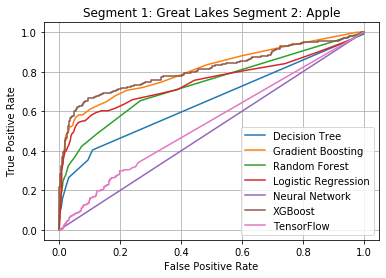

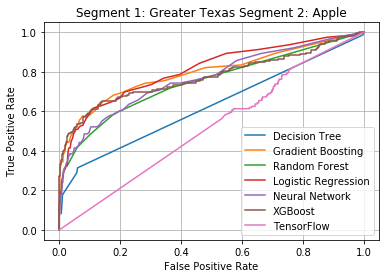

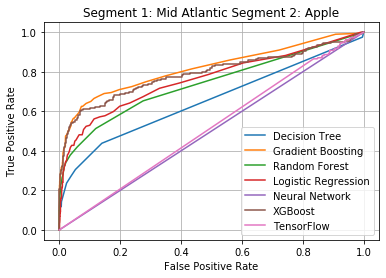

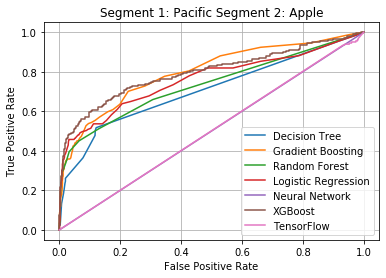

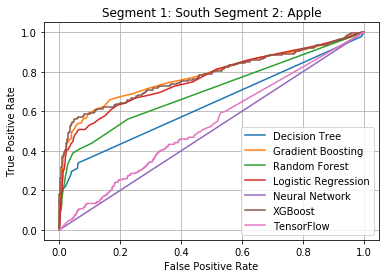

In [24]:
for m in segments_main:
    if not m['use']:
        continue
    plt.figure()
    for s in model_segments:
        if s['segment_id'] == m['segment_id']:
            
            rocinfo = s.get('ROCInfo')
            if rocinfo is not None:
                rocinfo = s.get('ROCInfo')
                
                plt.title('Segment 1: ' + str(m[segment1]) + ' Segment 2: ' + str(m[segment2]))
                plt.xlabel("False Positive Rate")
                plt.ylabel("True Positive Rate")
                plt.grid(True)
                plt.plot(rocinfo["FPR"], rocinfo["Sensitivity"], label=s['model'])
                plt.legend(loc="best")

#### Lift Charts

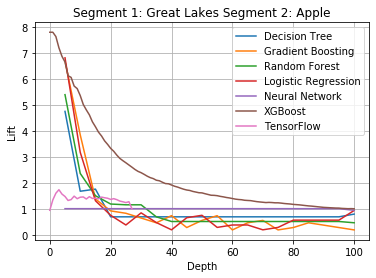

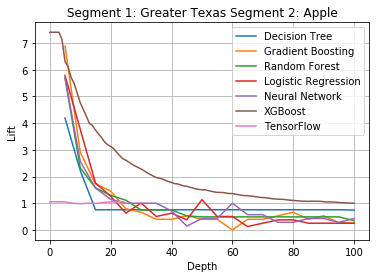

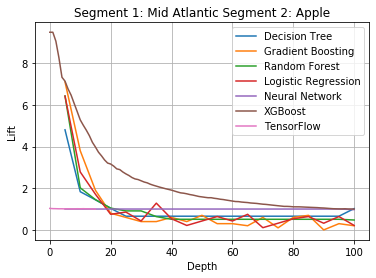

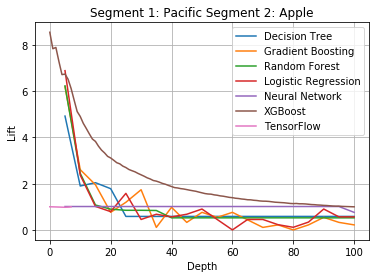

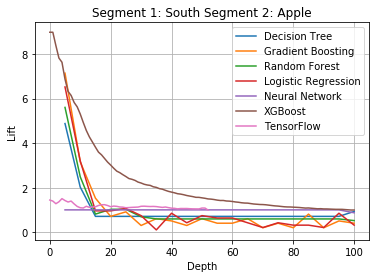

In [25]:
for m in segments_main:
    if not m['use']:
        continue
    plt.figure()
    for s in model_segments:
        if s['segment_id'] == m['segment_id']:
            rocinfo = s.get('LIFTInfo')
            if rocinfo is not None:
                plt.title('Segment 1: ' + str(m[segment1]) + ' Segment 2: ' + str(m[segment2]))
                plt.xlabel("Depth")
                plt.ylabel("Lift")
                plt.grid(True)
                if s['model'] in ['AutoML', 'XGBoost', 'TensorFlow']:
                    plt.plot(list(range(len(rocinfo))), rocinfo,label=s['model'])
                else:
                    plt.plot(rocinfo["Depth"], rocinfo["Lift"], label=s['model'])
                plt.legend(loc="best")

Summary of Results for All Segments

In [26]:
assess_res = [{'Segment ID': segment['segment_id'], segment1: segment[segment1], segment2: segment[segment2], 'Model': segment['model'], 'Misclassification': segment['misclassification'], 'Target Event Rate': segment['tgt_event_rate']} for segment in model_segments]

assess_pd = pd.DataFrame(assess_res, columns=['Segment ID', segment1, segment2, 'Model', 'Misclassification', 'Target Event Rate'])
assess_pd.set_index('Segment ID')

,region,handset,Model,Misclassification,Target Event Rate
Segment ID,,,,,
0,Great Lakes,Apple,Decision Tree,0.106969,0.117809
0,Great Lakes,Apple,Gradient Boosting,0.090222,0.117809
0,Great Lakes,Apple,Random Forest,0.125878,0.117809
0,Great Lakes,Apple,Logistic Regression,0.088061,0.117809
0,Great Lakes,Apple,Neural Network,0.126019,0.117809
0,Great Lakes,Apple,XGBoost,0.091302,0.117809
0,Great Lakes,Apple,TensorFlow,0.122096,0.117809
7,Greater Texas,Apple,Decision Tree,0.114566,0.133071
7,Greater Texas,Apple,Gradient Boosting,0.086743,0.133071


### Find and Display the Champion Model by Misclassification for Each Segment

In [27]:
def find_champion(models):
    misclass = [model['misclassification'] for model in models]
    lowest = min(misclass)
    idx = misclass.index(lowest)
    return models[idx]

champion_list = []

for segment in segments_main:
    if not segment['use']:
        continue
    all_models = [seg for seg in model_segments if segment[segment1] == seg[segment1] and segment[segment2] == seg[segment2]]
    champ = find_champion(all_models)
    champion_list.append({segment1 : champ[segment1], segment2: champ[segment2], 'Champion Model': champ['model'], 'Misclassification': champ['misclassification'], 'Target Event Rate': champ['tgt_event_rate']})

champion_pd = pd.DataFrame(champion_list, columns=[segment1, segment2, 'Champion Model', 'Misclassification', 'Target Event Rate'])
champion_pd

,region,handset,Champion Model,Misclassification,Target Event Rate
0,Great Lakes,Apple,Logistic Regression,0.088061,0.117809
1,Greater Texas,Apple,Gradient Boosting,0.086743,0.133071
2,Mid Atlantic,Apple,XGBoost,0.080958,0.111016
3,Pacific,Apple,Logistic Regression,0.085714,0.118254
4,South,Apple,XGBoost,0.080837,0.122075


### Find and Display Top Challenger Model by Misclassification for Each Segment

In [28]:
def find_challenger(models):
    misclass = [model['misclassification'] for model in models]
    lowest = min(misclass)
    misclass.remove(lowest)
    second_lowest = min(misclass)
    idx = misclass.index(second_lowest)
    return models[idx]

challenger_list = []

for segment in segments_main:
    if not segment['use']:
        continue
    all_models = [seg for seg in model_segments if segment[segment1] == seg[segment1] and segment[segment2] == seg[segment2]]
    challenge = find_challenger(all_models)
    challenger_list.append({segment1 : challenge[segment1], segment2: challenge[segment2], 'Challenger Model': challenge['model'], 'Misclassification': challenge['misclassification'], 'Target Event Rate': challenge['tgt_event_rate']})

challenger_pd = pd.DataFrame(challenger_list, columns=[segment1, segment2, 'Challenger Model', 'Misclassification', 'Target Event Rate'])
challenger_pd

,region,handset,Challenger Model,Misclassification,Target Event Rate
0,Great Lakes,Apple,Gradient Boosting,0.090222,0.117809
1,Greater Texas,Apple,Neural Network,0.110784,0.133071
2,Mid Atlantic,Apple,Gradient Boosting,0.083808,0.111016
3,Pacific,Apple,Neural Network,0.118847,0.118254
4,South,Apple,Gradient Boosting,0.083663,0.122075


#### Define Model Repository Variables

In [29]:
project_name=params_box.get(tab)['setup']['proj_name']
mm_segments = [str(segment[segment1]) + '_' + str(segment[segment2]) for segment in segments_main if segment['use']]
mm_models = params_box.get_models(tab)

#### Register Models and Save Model ID's

In [30]:
from sasctl.services import model_repository as mr
from sasctl import Session

with Session(viyahost, username, password, verify_ssl=False):
    for segment in mm_segments:
        project = {'id': '', 'models': [], 'segmentName': ''}
        segmentName = project_name + "_" + segment
        mr.create_project(project=segmentName, repository = 'Public',targetLevel = 'BINARY', function='classification',force=True)

        print("\nProject Name: ", segmentName)
        
        for model in mm_models:
            if champion_pd['Champion Model'][champion_pd['region']==segment.split('_')[0]][champion_pd['handset']==segment.split('_')[1]].values[0].replace(' ','') == model:
                mr.create_model(model=model,
                            project=segmentName, 
                            modeler= 'Paata U', 
                            function='classification', 
                            algorithm=model,
                            is_champion=True)
            elif challenger_pd['Challenger Model'][challenger_pd['region']==segment.split('_')[0]][challenger_pd['handset']==segment.split('_')[1]].values[0].replace(' ','') == model:
                mr.create_model(model=model,
                            project=segmentName, 
                            modeler= 'Paata U', 
                            function='classification', 
                            algorithm=model,
                            is_challenger=True)
            else:
                mr.create_model(model=model,
                            project=segmentName, 
                            modeler= 'Paata U', 
                            function='classification', 
                            algorithm=model)
            print("\nRegistered Model Name: ", model)

/opt/anaconda3/lib/python3.7/site-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)



Project Name:  LGDemoT_Great Lakes_Apple

Registered Model Name:  DecisionTree

Registered Model Name:  GradientBoosting

Registered Model Name:  RandomForest

Registered Model Name:  LogisticRegression

Registered Model Name:  NeuralNetwork

Registered Model Name:  XGBoost

Registered Model Name:  TensorFlow

Project Name:  LGDemoT_Greater Texas_Apple

Registered Model Name:  DecisionTree

Registered Model Name:  GradientBoosting

Registered Model Name:  RandomForest

Registered Model Name:  LogisticRegression

Registered Model Name:  NeuralNetwork

Registered Model Name:  XGBoost

Registered Model Name:  TensorFlow

Project Name:  LGDemoT_Mid Atlantic_Apple

Registered Model Name:  DecisionTree

Registered Model Name:  GradientBoosting

Registered Model Name:  RandomForest

Registered Model Name:  LogisticRegression

Registered Model Name:  NeuralNetwork

Registered Model Name:  XGBoost

Registered Model Name:  TensorFlow

Project Name:  LGDemoT_Pacific_Apple

Registered Model Name:

### Terminate All Sessions

In [31]:
for segment in model_segments:
    segment['session'].close()

#### *Check Out Your Model Repository and Models in SAS Model Manager on SAS Viya*